To do: must make it more adaptable to changes between odd vs even num of threads.

In [358]:
from PIL import Image, ImageDraw, ImageOps
import numpy as np

OVAL_RADIUS=20
LINE_THICKNESS=10
KNOT_HORIZ_SPACING=3*OVAL_RADIUS
KNOT_VERT_SPACING=int(KNOT_HORIZ_SPACING/2)-(OVAL_RADIUS)
HORIZ_MARGIN=80
VERT_MARGIN=40

black_arrows=[Image.open("Icons\FWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\FWDBWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWDFWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS))]

white_arrows=[Image.open("Icons\FWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\FWDBWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWDFWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS))]


def get_color_appropriate_arrow(arrow_index, color_hex):
    color_hex=color_hex.lstrip('#')

    r = int(color_hex[0:2], 16)
    g = int(color_hex[2:4], 16)
    b = int(color_hex[4:6], 16)

    luminance = (0.299 * r + 0.587 * g + 0.114 * b) / 255

    if(luminance<0.5): # if dark
        return white_arrows[arrow_index]
    else:
        return black_arrows[arrow_index]
    

def get_knot_result(arrow_index, left_color, right_color):
    knot_color=None
    left_out_color=None
    right_out_color=None

    if(arrow_index==0 or arrow_index==2): # fwd or fwdbwd
        knot_color=left_color
    else: # bwd or bwdfwd
        knot_color=right_color


    if(arrow_index==0 or arrow_index==1): # fwd or bwd
        left_out_color=right_color
        right_out_color=left_color
    else: # fwdbwd or bwdfwrd
        left_out_color=left_color
        right_out_color=right_color

    return knot_color, left_out_color, right_out_color


- FWD: 0
- BWD: 1
- FWDBWD: 2
- BWDFWD: 3
- NO KNOT: -1

# Threads Array Generation

In [359]:
#############################
# For testing
#############################

knots_array=[[0, 1, 1, 3],
             [0, 0, 0,0],
             [3, 2, 2, 0],
             [0, 0, 0,0]]

initial_threads=['#ffff00', '#ff0000', '#0000ff', '#ff0000','#ff0000','#ff0000','#ff0000','#ffff00','#ff0000']

def get_threads_array(knots_arr, initial_threads):
    threads_arr=[initial_threads]

    num_rows=len(knots_arr)
    num_threads=len(threads_arr[0])
    num_cols=int(np.floor(float(num_threads)/2))

    ##############################

    for row in range(num_rows):
        threads_row=threads_arr[-1]
        new_threads_row=[]
        if(row%2!=0): # if row is odd
            new_threads_row.append(threads_row[0])

        for col in range(num_cols):
            if(row%2==0): # if row is even
                left_in=threads_row[col*2]
                right_in=threads_row[(col*2)+1]
            else: # if row is odd
                if(num_threads%2==0 and col==num_cols-1): # if num of threads is even and we reached end of row
                    new_threads_row.append(threads_row[-1])
                    continue # no knot
                left_in=threads_row[(col*2)+1]
                right_in=threads_row[(col*2)+2]
            color_hex, left_out, right_out =get_knot_result(knots_arr[row][col],left_in, right_in)

            new_threads_row.append(left_out)
            new_threads_row.append(right_out)
        if(num_threads%2!=0 and row%2==0):
            new_threads_row.append(threads_row[-1])
        threads_arr.append(new_threads_row)
    return threads_arr

threads_array=get_threads_array(knots_array, initial_threads)


# Visualization

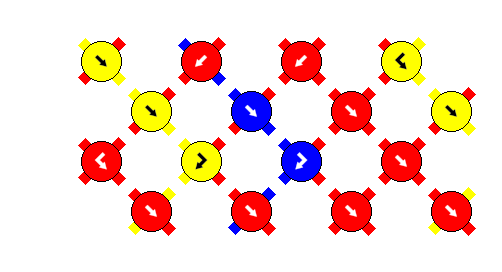

In [360]:
def display_diagram(knots_arr, threads_arr):
    num_rows=len(knots_arr)
    num_threads=len(threads_arr[0])
    num_cols=int(np.floor(float(num_threads)/2))
    
    # Initializing the base image
    image_width=HORIZ_MARGIN*2+(num_cols*OVAL_RADIUS*2)+((num_cols-1)*KNOT_HORIZ_SPACING)
    image_height=VERT_MARGIN*2+(num_rows*OVAL_RADIUS*2)+((num_rows-1)*KNOT_VERT_SPACING)

    image = Image.new('RGBA',(image_width, image_height))

    draw = ImageDraw.Draw(image)

    for row in range(num_rows):
        threads_row=threads_arr[row]

        for col in range(num_cols):

            if(row%2==0): # if row is even
                oval_x_start=int(HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                left_in=threads_arr[row][col*2]
                right_in=threads_arr[row][(col*2)+1]
            else: # if row is odd
                oval_x_start=int((OVAL_RADIUS)+(KNOT_HORIZ_SPACING/2)+HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                if(num_threads%2==0 and col==num_cols-1): # if num of threads is even and we reached end of row
                    continue # no knot
                left_in=threads_arr[row][(col*2)+1]
                right_in=threads_arr[row][(col*2)+2]
            
            oval_y_start=int(VERT_MARGIN+(2*row*OVAL_RADIUS)+(row*KNOT_VERT_SPACING))
            
            color_hex, left_out, right_out =get_knot_result(knots_arr[row][col],left_in, right_in)

            draw.line([(oval_x_start,oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=left_in, width=LINE_THICKNESS)
            draw.line([(oval_x_start+(2*OVAL_RADIUS),oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=right_in, width=LINE_THICKNESS)
            draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start+(2*OVAL_RADIUS),oval_y_start+(2*OVAL_RADIUS))], fill=right_out, width=LINE_THICKNESS)
            draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start,oval_y_start+(2*OVAL_RADIUS))], fill=left_out, width=LINE_THICKNESS)
            
            arrow=get_color_appropriate_arrow(knots_arr[row][col], color_hex=color_hex)
            draw.ellipse((oval_x_start, oval_y_start, oval_x_start+OVAL_RADIUS*2, oval_y_start+OVAL_RADIUS*2), fill = color_hex, outline='black')
            
            image.paste(arrow, (oval_x_start+int(OVAL_RADIUS/2), oval_y_start+int(OVAL_RADIUS/2)),arrow)

    image=ImageOps.expand(image, border=1, fill='white')
    display(image)

display_diagram(knots_array, threads_array)


[['#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000']]
[['#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00']]
[['#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00'], ['#ff0000', '#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00']]
[['#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ffff00'

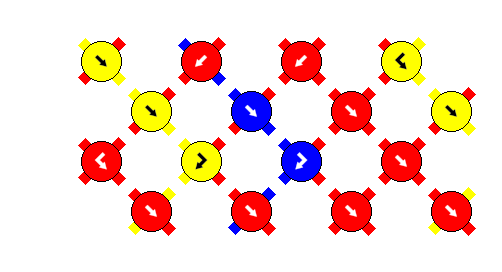

In [361]:
class Knot:
    def __init__(self, row, col, knot_type, left_in, right_in):
        self.row = row
        self.col = col
        self.knot_type = knot_type
        self.left_in = left_in
        self.right_in = right_in
        self.input_colors = [left_in, right_in]
        self.get_knot_result()
        self.output_colors = [self.left_out, self.right_out]

    def get_knot_result(self):
        self.knot_color=None
        self.left_out=None
        self.right_out=None

        if(self.knot_type==0 or self.knot_type==2): # fwd or fwdbwd
            self.knot_color=self.left_in
        else: # bwd or bwdfwd
            self.knot_color=self.right_in


        if(self.knot_type==0 or self.knot_type==1): # fwd or bwd
            self.left_out=self.right_in
            self.right_out=self.left_in
        else: # fwdbwd or bwdfwrd
            self.left_out=self.left_in
            self.right_out=self.right_in
    def involves_color(self, color):
        return color in self.input_colors

class Bracelet:
    def __init__(self, initial_threads):
        self.threads=[initial_threads]
        self.num_threads=len(self.threads[0])
        self.symmetric=self.num_threads%2==0
        self.knots_array=[]
        self.num_rows=0
        self.num_cols=int(np.floor(float(self.num_threads)/2))
    
        '''    def get_left_parent(self, current_knot):
        if(self.symmetric):
            if(current_knot.row%2==0): # if row of knot is even

            else:
        else:
            if(current_knot.row%2==0): # if row of knot is even
            else:'''

    def add_knots_row(self, knot_types):
        knots_row=[]
        new_threads_row=[]
        new_row=self.num_rows

        if(new_row%2!=0): # new row is odd
            new_threads_row.append(self.threads[-1][0])

        for new_col, knot_t in enumerate(knot_types):
            if(new_row%2==0): # row is even
                left_in=self.threads[-1][2*new_col]
                right_in=self.threads[-1][(2*new_col)+1]
            else: # row is odd
                left_in=self.threads[-1][(2*new_col)+1]
                right_in=self.threads[-1][(2*new_col)+2]
            
            knots_row.append(Knot(new_row, new_col,knot_t,left_in, right_in))
            
            new_threads_row.append(knots_row[-1].left_out)
            new_threads_row.append(knots_row[-1].right_out)

        if((self.symmetric and new_row%2!=0) or (not self.symmetric and new_row%2==0)):
            new_threads_row.append(self.threads[-1][-1])  
              
        self.knots_array.append(knots_row)
        self.threads.append(new_threads_row)
        self.num_rows+=1
        print(self.threads)

    def display(self):
        # Initializing the base image
        image_width=HORIZ_MARGIN*2+(self.num_cols*OVAL_RADIUS*2)+((self.num_cols-1)*KNOT_HORIZ_SPACING)
        image_height=VERT_MARGIN*2+(self.num_rows*OVAL_RADIUS*2)+((self.num_rows-1)*KNOT_VERT_SPACING)

        image = Image.new('RGBA',(image_width, image_height))

        draw = ImageDraw.Draw(image)

        for row in range(self.num_rows):
            threads_row=self.threads[row]

            for col in range(self.num_cols):

                if(row%2==0): # if row is even
                    oval_x_start=int(HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                    left_in=self.threads[row][col*2]
                    right_in=self.threads[row][(col*2)+1]
                else: # if row is odd
                    oval_x_start=int((OVAL_RADIUS)+(KNOT_HORIZ_SPACING/2)+HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                    if(self.num_threads%2==0 and col==self.num_cols-1): # if num of threads is even and we reached end of row
                        continue # no knot
                    left_in=self.threads[row][(col*2)+1]
                    right_in=self.threads[row][(col*2)+2]
                
                oval_y_start=int(VERT_MARGIN+(2*row*OVAL_RADIUS)+(row*KNOT_VERT_SPACING))
                
                color_hex=self.knots_array[row][col].knot_color
                left_out=self.knots_array[row][col].left_out
                right_out=self.knots_array[row][col].right_out

                draw.line([(oval_x_start,oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=left_in, width=LINE_THICKNESS)
                draw.line([(oval_x_start+(2*OVAL_RADIUS),oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=right_in, width=LINE_THICKNESS)
                draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start+(2*OVAL_RADIUS),oval_y_start+(2*OVAL_RADIUS))], fill=right_out, width=LINE_THICKNESS)
                draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start,oval_y_start+(2*OVAL_RADIUS))], fill=left_out, width=LINE_THICKNESS)
                
                arrow=get_color_appropriate_arrow(self.knots_array[row][col].knot_type, color_hex=color_hex)
                draw.ellipse((oval_x_start, oval_y_start, oval_x_start+OVAL_RADIUS*2, oval_y_start+OVAL_RADIUS*2), fill = color_hex, outline='black')
                
                image.paste(arrow, (oval_x_start+int(OVAL_RADIUS/2), oval_y_start+int(OVAL_RADIUS/2)),arrow)

        image=ImageOps.expand(image, border=1, fill='white')
        display(image)
bracelet=Bracelet(initial_threads)
for k_row in knots_array:
    bracelet.add_knots_row(k_row)
bracelet.display()


In [362]:
# This code is from chatGPT (I'm only human after all)
from itertools import product

# Generate all combinations of distributing 'extra' threads among colors
# This is equivalent to integer compositions of 'extra' into len(colors) parts
def generate_extra_combinations(n, k):
    if k == 1:
        yield (n,)
    else:
        for i in range(n + 1):
            for tail in generate_extra_combinations(n - i, k - 1):
                yield (i,) + tail

In [ ]:
import random
import pandas as pd
import copy

#NoPossibleSolution = Exception("NO POSSIBLE SOLUTION")
class NoPossibleSolution(Exception):
    pass

NONE_VALUE='#808080'

class Thread:
    def __init__(self, possibilities):
        self.locked=False
        self.possibilities=possibilities
        self.final_value = NONE_VALUE
    def remove_possibility(self, possibility):
        if(possibility in self.possibilities):
            self.possibilities.remove(possibility)
            return self.updateState()
        else:
            return 0 # no changes made
    def remove_possibility_by_idx(self, idx):
        self.possibilities.pop(idx)
        return self.updateState()
    def updateState(self):
        if(len(self.possibilities)==1):
            self.setFinalValue(self.possibilities[0])
            return 1
        elif(len(self.possibilities)<1):
            return -1
        else:
            return len(self.possibilities)
    def setFinalValue(self, val):
        if(val not in self.possibilities):
            return -1
        elif(self.final_value == val):
            return 0 # no changes made
        else:
            self.possibilities=[val]
            self.final_value=val
            return 1

    def lock(self):
        self.locked=True
    def isLocked(self):
        return self.locked

class ThreadsGrid:
    def __init__(self, num_threads, colors):
        self.num_rows=0
        self.num_threads=num_threads
        self.colors=colors
        self.grid=[]

    def add_row(self):
        new_row=[]
        for i in range(self.num_threads):
            new_row.append(Thread(possibilities=copy.deepcopy(self.colors)))
        self.grid.append(new_row)
        self.num_rows+=1

class Solver:
    def __init__(self, target_design):
        self.target_design=target_design
        # figure out colors
        self.colors=set(target_design[0])
        for row in target_design:
            self.colors.update(row)
        self.colors=list(self.colors)

        # figure out num of rows needed
        self.num_rows=len(target_design)+1

        # figure out num of threads needed
        self.num_threads=len(target_design[0])*2
        if(len(target_design[0])==len(target_design[1])): # if number of knots is constant across rows, num of threads must be odd
            self.num_threads+=1
        
        self.symmetric=False
        if(self.num_threads%2==0):
            self.symmetric=True

        # instantiate ThreadsGrid
        self.threads_grid = ThreadsGrid(self.num_threads, self.colors)

        for i in range(self.num_rows):
            self.threads_grid.add_row()

        # locking left side
        for i in range(self.num_rows):
            if(i%2!=0):
                self.threads_grid.grid[i][0].lock()
            
        # locking right side
        for i in range(self.num_rows):
            if((self.symmetric and i%2!=0) or (not self.symmetric and i%2==0)):
                self.threads_grid.grid[i][-1].lock()
        
        # calculate possible color combos
        self.color_combos=self.get_color_combos()

    def get_color_combos(self):
        min_threads_per_color={}
        min_threads_per_color_sum=0
        # for each color, you need a minimum number of threads of n, where n is the max num of knots in that color in the same row
        for c in self.colors:
            c_max_knots=0
            for row in self.target_design:
                # count num of knots of that color in that row
                n_knots=0
                for knot in row:
                    if(knot==c):
                        n_knots+=1
                if(n_knots>c_max_knots):
                    c_max_knots=n_knots
            min_threads_per_color[c]=c_max_knots
            min_threads_per_color_sum+=c_max_knots

        # if sum of min threads per color is more than num of threads, solution is impossible
        if(min_threads_per_color_sum>self.num_threads):
            print(min_threads_per_color)
            print(self.num_threads)
            raise NoPossibleSolution
        elif(min_threads_per_color_sum==self.num_threads):
            return [min_threads_per_color]
        else:
            combos=[]
            DoF = self.num_threads-min_threads_per_color_sum # Degrees of Freedom: number of threads that can be any color
            mins = list(min_threads_per_color.values())

            for extra_combo in generate_extra_combinations(DoF, len(self.colors)):
                dist = {color: mins[i] + extra_combo[i] for i, color in enumerate(self.colors)}
                combos.append(dist)
            
            return combos
    
    def get_goal_color(self, row, col):
        row=row%self.num_rows # because first row will be repeated and might cause index out of range error
        if(row%2==0): # even row
            return self.target_design[row][int(np.floor(col/2))]
        else: # odd row
            return self.target_design[row][int(np.floor((col-1)/2))]
        
    def get_knot_input_threads(self, row, col): # returns [[row1, col1], [row2, col2]]
        if(row%2==0): # even row
            return [[row,col*2],[row,(col*2)+1]]
        else: # odd row
            return [[row,(col*2)+1],[row,(col*2)+2]]
    
    def get_knot_output_threads(self, row, col): # returns [[row1, col1], [row2, col2]]
        if(row%2==0): # even row
            return [[row+1,col*2],[row+1,(col*2)+1]]
        else: # odd row
            return [[row+1,(col*2)+1],[row+1,(col*2)+2]]
        
    def check_for_completion(self):
        for thread_row in self.threads_grid.grid:
            for thread in thread_row:
                if(thread.final_value==NONE_VALUE):
                    return False
        return True
            
        
    def update_possibilities(self, threads_per_color_dict): # according to the 5 rules. Returns a flag that says whether changes were made
        changes_made=False
        # 1. Num of threads per color should be constant across rows
        for i, row in enumerate(self.threads_grid.grid):
            for c in self.colors:
                # count that color in that row
                color_ctr=0
                for thread in row:
                    if(thread.final_value==c):
                        color_ctr+=1
                if(color_ctr==threads_per_color_dict[c]):
                    # remove that color's possibility from other threads
                    for thread in row:
                        removal_result=thread.remove_possibility(c)
                        if(removal_result!=0):
                            changes_made=True
                        if(removal_result==-1):
                            print("--Rule 1 failure: row "+str(i)+".") # log
                            raise NoPossibleSolution
                        
        print("--Rule 1 passed") # log
        #self.display_possibilities() # log

        # 2. At least one of the two threads before the knot should have the goal color of that knot
        for kr, knot_row in enumerate(self.target_design):
            for k, knot_color in enumerate(knot_row):
                input_thread_corrds=self.get_knot_input_threads(kr, k)
                t1_row=input_thread_corrds[0][0]
                t1_col=input_thread_corrds[0][1]
                t2_row=input_thread_corrds[1][0]
                t2_col=input_thread_corrds[1][1]

                # if only one of them has the color as a possibility, make the color final_value for that thread
                if(knot_color in self.threads_grid.grid[t1_row][t1_col].possibilities and not knot_color in self.threads_grid.grid[t2_row][t2_col].possibilities):
                    setterResult=self.threads_grid.grid[t1_row][t1_col].setFinalValue(knot_color)
                    if(setterResult!=0):
                        changes_made=True
                    elif(setterResult==-1):
                        print("--Rule 2 failure: setting grid["+str(t1_row)+"]["+t1_col+"] to "+knot_color+" failed.") # log
                        raise NoPossibleSolution
                elif(knot_color in self.threads_grid.grid[t2_row][t2_col].possibilities and not knot_color in self.threads_grid.grid[t1_row][t1_col].possibilities):
                    setterResult=self.threads_grid.grid[t2_row][t2_col].setFinalValue(knot_color)
                    if(setterResult!=0):
                        changes_made=True
                    elif(setterResult==-1):
                        print("--Rule 2 failure: setting grid["+str(t2_row)+"]["+t2_col+"] to "+knot_color+" failed.") # log
                        raise NoPossibleSolution

                # if none of them has the color as a possibility, solution failed
                elif(not knot_color in self.threads_grid.grid[t2_row][t2_col].possibilities and not knot_color in self.threads_grid.grid[t1_row][t1_col].possibilities):
                    print("Knot color: "+knot_color)
                    print(self.threads_grid.grid[t1_row][t1_col].possibilities)
                    print(self.threads_grid.grid[t2_row][t2_col].possibilities)
                    print("--Rule 2 failure: knot color "+knot_color+" not in grid["+str(t1_row)+"]["+str(t1_col)+"] nor in grid["+str(t2_row)+"]["+str(t2_col)+"]") # log
                    raise NoPossibleSolution
        
        print("--Rule 2 passed") # log
        #self.display_possibilities() # log

        # 3. Locked threads should have the same color as itself in the next row
        for row_idx in range(self.num_rows-1):
            for col_idx, thread in enumerate(self.threads_grid.grid[row_idx]):
                if(thread.isLocked()):
                    # remove the colors specific to only one of them from both of their possibilities
                    t1_possibilities=set(self.threads_grid.grid[row_idx][col_idx].possibilities)
                    t2_possibilities=set(self.threads_grid.grid[row_idx+1][col_idx].possibilities)
                    c_to_remove=list((t1_possibilities|t2_possibilities)-(t1_possibilities&t2_possibilities)) # their union minus their intersection
                    for c in c_to_remove:
                        removal_result1=self.threads_grid.grid[row_idx][col_idx].remove_possibility(c)
                        removal_result2=self.threads_grid.grid[row_idx+1][col_idx].remove_possibility(c)
                        if(removal_result1!=0 or removal_result2!=0):
                            changes_made=True

                        if(removal_result1==-1 or removal_result2==-1):
                            print("--Rule 3 failure: grid["+str(row_idx)+"-"+str(row_idx+1)+"]["+str(col_idx)+"]") # log
                            raise NoPossibleSolution
        
        print("--Rule 3 passed") # log
        #self.display_possibilities() # log
        
        # 4. Moving pairs can either switch or stay in place
        # In other words, threads exiting a knot have to be the same colors as those entering the knot
        for kr, knot_row in enumerate(self.target_design):
            for k, knot_color in enumerate(knot_row):
                input_thread_corrds=self.get_knot_input_threads(kr, k)
                left_in_row=input_thread_corrds[0][0]
                left_in_col=input_thread_corrds[0][1]
                right_in_row=input_thread_corrds[1][0]
                right_in_col=input_thread_corrds[1][1]

                output_thread_corrds=self.get_knot_output_threads(kr, k)
                left_out_row=output_thread_corrds[0][0]
                left_out_col=output_thread_corrds[0][1]
                right_out_row=output_thread_corrds[1][0]
                right_out_col=output_thread_corrds[1][1]

                # if a possibility is only present after a knot, or only before the knot, remove that possibility
                input_possibilities=set(self.threads_grid.grid[left_in_row][left_in_col].possibilities)|set(self.threads_grid.grid[right_in_row][right_in_col].possibilities)
                output_possibilities=set(self.threads_grid.grid[left_out_row][left_out_col].possibilities)|set(self.threads_grid.grid[right_out_row][right_out_col].possibilities)
                c_to_remove=list((input_possibilities|output_possibilities)-(input_possibilities&output_possibilities)) # their union minus their intersection

                for c in c_to_remove:
                    removal_results=[]
                    removal_results.append(self.threads_grid.grid[left_in_row][left_in_col].remove_possibility(c))
                    removal_results.append(self.threads_grid.grid[right_in_row][right_in_col].remove_possibility(c))
                    removal_results.append(self.threads_grid.grid[left_out_row][left_out_col].remove_possibility(c))
                    removal_results.append(self.threads_grid.grid[right_out_row][right_out_col].remove_possibility(c))
                    removal_results=set(removal_results)
                    if(removal_results!=set([0])):
                        changes_made=True

                    if(-1 in removal_results):
                        print("--Rule 4 failure: removing "+c+" from grid["+str(left_in_row)+"-"+str(left_out_row)+"]["+str(left_in_col)+"-"+str(right_out_col)+"] failed.") # log
                        raise NoPossibleSolution

                # if a final value is established on either side of the knot (vertically) 
                # if none of the threads on the other side has it as a possibility, solution fails
                # if only one of the threads on the other side has it as a possibility, make it its final value
                if(self.threads_grid.grid[left_in_row][left_in_col].final_value!=NONE_VALUE):
                    fv=self.threads_grid.grid[left_in_row][left_in_col].final_value
                    if(not (fv in output_possibilities)):
                        print("--Rule 4 failure: "+fv+" is not in output possibilities of grid["+str(left_in_row)+"]["+str(left_in_col)+"]") # log
                        raise NoPossibleSolution
                    elif(fv in self.threads_grid.grid[left_out_row][left_out_col].possibilities and not fv in self.threads_grid.grid[right_out_row][right_out_col].possibilities):
                        setterResult=self.threads_grid.grid[left_out_row][left_out_col].setFinalValue(fv)
                    elif(fv in self.threads_grid.grid[right_out_row][right_out_col].possibilities and not fv in self.threads_grid.grid[left_out_row][left_out_col].possibilities):
                        setterResult=self.threads_grid.grid[right_out_row][right_out_col].setFinalValue(fv)
                    else:
                        setterResult=0

                    if(setterResult!=0):
                        changes_made=True
                    elif(setterResult==-1):
                        print("--Rule 4 failure: could not set one of grid["+str(left_out_row)+"]["+str(left_out_col)+"-"+str(right_out_col)+"] to "+fv) # log
                        raise NoPossibleSolution
                
                if(self.threads_grid.grid[right_in_row][right_in_col].final_value!=NONE_VALUE):
                    fv=self.threads_grid.grid[right_in_row][right_in_col].final_value
                    if(not (fv in output_possibilities)):
                        print("--Rule 4 failure: "+fv+" is not in output possibilities of grid["+str(right_in_row)+"]["+str(right_in_col)+"]") # log
                        raise NoPossibleSolution
                    elif(fv in self.threads_grid.grid[left_out_row][left_out_col].possibilities and not fv in self.threads_grid.grid[right_out_row][right_out_col].possibilities):
                        setterResult=self.threads_grid.grid[left_out_row][left_out_col].setFinalValue(fv)
                    elif(fv in self.threads_grid.grid[right_out_row][right_out_col].possibilities and not fv in self.threads_grid.grid[left_out_row][left_out_col].possibilities):
                        setterResult=self.threads_grid.grid[right_out_row][right_out_col].setFinalValue(fv)
                    else:
                        setterResult=0

                    if(setterResult!=0):
                        changes_made=True
                    elif(setterResult==-1):
                        print("--Rule 4 failure: could not set one of grid["+str(left_out_row)+"]["+str(left_out_col)+"-"+str(right_out_col)+"] to "+fv) # log
                        raise NoPossibleSolution
                    
                if(self.threads_grid.grid[left_out_row][left_out_col].final_value!=NONE_VALUE):
                    fv=self.threads_grid.grid[left_out_row][left_out_col].final_value
                    if(not (fv in input_possibilities)):
                        print("--Rule 4 failure: "+fv+" is not in output possibilities of grid["+str(left_out_row)+"]["+str(left_out_col)+"]") # log
                        raise NoPossibleSolution
                    elif(fv in self.threads_grid.grid[left_in_row][left_in_col].possibilities and not fv in self.threads_grid.grid[right_in_row][right_in_col].possibilities):
                        setterResult=self.threads_grid.grid[left_in_row][left_in_col].setFinalValue(fv)
                    elif(fv in self.threads_grid.grid[right_in_row][right_in_col].possibilities and not fv in self.threads_grid.grid[left_in_row][left_in_col].possibilities):
                        setterResult=self.threads_grid.grid[right_in_row][right_in_col].setFinalValue(fv)
                    else:
                        setterResult=0

                    if(setterResult!=0):
                        changes_made=True
                    elif(setterResult==-1):
                        print("--Rule 4 failure: could not set one of grid["+str(left_in_row)+"]["+str(left_in_col)+"-"+str(right_in_col)+"] to "+fv) # log
                        raise NoPossibleSolution
                    
                if(self.threads_grid.grid[right_out_row][right_out_col].final_value!=NONE_VALUE):
                    fv=self.threads_grid.grid[right_out_row][right_out_col].final_value
                    if(not (fv in input_possibilities)):
                        print("--Rule 4 failure: "+fv+" is not in output possibilities of grid["+str(right_out_row)+"]["+str(right_out_col)+"]") # log
                        raise NoPossibleSolution
                    elif(fv in self.threads_grid.grid[left_in_row][left_in_col].possibilities and not fv in self.threads_grid.grid[right_in_row][right_in_col].possibilities):
                        setterResult=self.threads_grid.grid[left_in_row][left_in_col].setFinalValue(fv)
                    elif(fv in self.threads_grid.grid[right_in_row][right_in_col].possibilities and not fv in self.threads_grid.grid[left_in_row][left_in_col].possibilities):
                        setterResult=self.threads_grid.grid[right_in_row][right_in_col].setFinalValue(fv)
                    else:
                        setterResult=0

                    if(setterResult!=0):
                        changes_made=True
                    elif(setterResult==-1):
                        print("--Rule 4 failure: could not set one of grid["+str(left_in_row)+"]["+str(left_in_col)+"-"+str(right_in_col)+"] to "+fv) # log
                        raise NoPossibleSolution
        
        print("--Rule 4 passed") # log
        #self.display_possibilities() # log
        
        # 5. Final threads should be the same as the initial threads
        for col_idx, thread in enumerate(self.threads_grid.grid[-1]):
            print("Checking column "+str(col_idx)) # log
            #self.display_possibilities()
            # remove the colors specific to only one of them from both of their possibilities
            t1_possibilities=set(self.threads_grid.grid[-1][col_idx].possibilities) # last row
            t2_possibilities=set(self.threads_grid.grid[0][col_idx].possibilities) # first row
            c_to_remove=list((t1_possibilities|t2_possibilities)-(t1_possibilities&t2_possibilities)) # their union minus their intersection

            for c in c_to_remove:
                removal_result1=self.threads_grid.grid[-1][col_idx].remove_possibility(c) # last row
                #print("Removing "+c+" from column "+str(col_idx)+" last row") # log
                #self.display_possibilities() # log      
                removal_result2=self.threads_grid.grid[0][col_idx].remove_possibility(c) # first row
                #print("Removing "+c+" from column "+str(col_idx)+" first row") # log
                #self.display_possibilities() # log
                if(removal_result1!=0 or removal_result2!=0):
                    changes_made=True

                if(removal_result1==-1 or removal_result2==-1):
                    print("--Rule 5 failure: cannot remove "+c+" possibility from thread "+str(col_idx)) # log
                    raise NoPossibleSolution
        
        print("--Rule 5 passed") # log        
        #self.display_possibilities() # log
        
        # Return flag
        return changes_made
    
    def get_least_uncertain_thread(self): # excludes those with final value
        least_uncertain_thread_row=0
        least_uncertain_thread_col=0
        least_possibilities=len(self.colors)
        for tr, thread_row in enumerate(self.threads_grid.grid):
            for tc, thread in enumerate(thread_row):
                if(len(thread.possibilities)<least_possibilities and len(thread.possibilities)>1):
                    least_uncertain_thread_row=tr
                    least_uncertain_thread_col=tc
                    least_possibilities=len(thread.possibilities)
        return least_uncertain_thread_row, least_uncertain_thread_col

    

    
    def _solve(self, combo):
        # Update possibilities
        ctr=0
        changes_made=1 # arbitrary value >0
        while(changes_made!=0):
            print("Current possibilities: ") # log
            #self.display_possibilities() # log
            self.display_diagram() # log
            changes_made=self.update_possibilities(combo)
            if(ctr>10000):
                raise Exception("Max iterations exceeded")
        print("Updated possibilities "+str(ctr)+" times.") # log
        if(self.check_for_completion()):
            print("Solution is complete.") # log
            return 0
        else:
            # Make a random possibility selection
            pre_change_threads_grid = copy.deepcopy(self.threads_grid)
            least_uncertain_thread_row, least_uncertain_thread_col=self.get_least_uncertain_thread()
            print("------") # log
            print("Least uncertain thread: grid["+str(least_uncertain_thread_row)+"]["+str(least_uncertain_thread_col)+"]") # log
            possibilities=self.threads_grid.grid[least_uncertain_thread_row][least_uncertain_thread_col].possibilities
            random.shuffle(possibilities)
            print("Trying possibilities: "+str(possibilities)) # log
            for poss in random.sample(possibilities, len(possibilities)):
                print("- grid["+str(least_uncertain_thread_row)+"]["+str(least_uncertain_thread_col)+"] = "+poss) # log
                setterResult=self.threads_grid.grid[least_uncertain_thread_row][least_uncertain_thread_col].setFinalValue(poss)
                if(setterResult==-1):
                    self.threads_grid=pre_change_threads_grid
                    print("- FAILURE: cannot set grid["+str(least_uncertain_thread_row)+"]["+str(least_uncertain_thread_col)+"] to "+poss) # log
                    continue
                try:
                    if(self._solve(combo)==0):
                        return 0
                except NoPossibleSolution:
                    self.threads_grid=pre_change_threads_grid
                    print("- FAILURE: grid["+str(least_uncertain_thread_row)+"]["+str(least_uncertain_thread_col)+"] = "+poss) # log
                    print("Possibilities: "+str(possibilities)) # log
                    continue
            # if none of the possibilities worked out
            raise NoPossibleSolution
        
    def solve(self):
        print("Starting solution. Calculated combinations:") # log
        for combo in self.color_combos: # log
            print(combo) # log
        print("-----------------") # log
        for combo in self.color_combos:
            print("Trying combo:") # log
            print(combo) # log
            try:
                if(self._solve(combo)==0):
                    return 0
            except NoPossibleSolution:
                continue
        # if none of the combos worked out
        raise NoPossibleSolution

    def display_possibilities(self):
        display(pd.DataFrame([
            [", ".join(str(p) for p in thread.possibilities) for thread in row]
            for row in self.threads_grid.grid
        ]))



    def display_diagram(self):
        threads_arr=self.threads_grid.grid
        num_rows=len(threads_arr)-1
        num_threads=len(threads_arr[0])
        num_cols=int(np.floor(float(num_threads)/2))
        
        # Initializing the base image
        image_width=HORIZ_MARGIN*2+(num_cols*OVAL_RADIUS*2)+((num_cols-1)*KNOT_HORIZ_SPACING)
        image_height=VERT_MARGIN*2+(num_rows*OVAL_RADIUS*2)+((num_rows-1)*KNOT_VERT_SPACING)

        image = Image.new('RGBA',(image_width, image_height))

        draw = ImageDraw.Draw(image)

        for row in range(num_rows):
            threads_row=threads_arr[row]

            for col in range(num_cols):

                if(row%2==0): # if row is even
                    oval_x_start=int(HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                    left_in=threads_arr[row][col*2].final_value
                    right_in=threads_arr[row][(col*2)+1].final_value
                    left_out=threads_arr[row+1][(col*2)+1].final_value
                    right_out=threads_arr[row+1][(col*2)+2].final_value
                else: # if row is odd
                    oval_x_start=int((OVAL_RADIUS)+(KNOT_HORIZ_SPACING/2)+HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                    if(num_threads%2==0 and col==num_cols-1): # if num of threads is even and we reached end of row
                        continue # no knot
                    left_in=threads_arr[row][(col*2)+1].final_value
                    right_in=threads_arr[row][(col*2)+2].final_value
                    left_out=threads_arr[row+1][col*2].final_value
                    right_out=threads_arr[row+1][(col*2)+1].final_value
                
                oval_y_start=int(VERT_MARGIN+(2*row*OVAL_RADIUS)+(row*KNOT_VERT_SPACING))
                
                color_hex=self.target_design[row][col]

                draw.line([(oval_x_start,oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=left_in, width=LINE_THICKNESS)
                draw.line([(oval_x_start+(2*OVAL_RADIUS),oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=right_in, width=LINE_THICKNESS)
                draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start+(2*OVAL_RADIUS),oval_y_start+(2*OVAL_RADIUS))], fill=right_out, width=LINE_THICKNESS)
                draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start,oval_y_start+(2*OVAL_RADIUS))], fill=left_out, width=LINE_THICKNESS)
                
                draw.ellipse((oval_x_start, oval_y_start, oval_x_start+OVAL_RADIUS*2, oval_y_start+OVAL_RADIUS*2), fill = color_hex, outline='black')

        image=ImageOps.expand(image, border=1, fill='white')
        display(image)


Starting solution. Calculated combinations:
{'#ffff00': 2, '#0000ff': 1, '#ff0000': 6}
{'#ffff00': 2, '#0000ff': 2, '#ff0000': 5}
{'#ffff00': 2, '#0000ff': 3, '#ff0000': 4}
{'#ffff00': 3, '#0000ff': 1, '#ff0000': 5}
{'#ffff00': 3, '#0000ff': 2, '#ff0000': 4}
{'#ffff00': 4, '#0000ff': 1, '#ff0000': 4}
-----------------
Trying combo:
{'#ffff00': 2, '#0000ff': 1, '#ff0000': 6}
Current possibilities: 


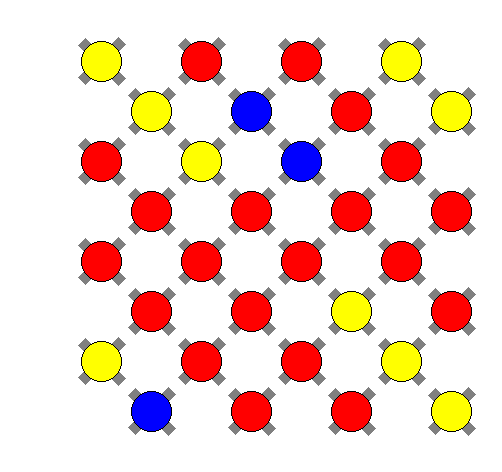

--Rule 1 passed
--Rule 2 passed
--Rule 3 passed
--Rule 4 passed
Checking column 0
Checking column 1
Checking column 2
Checking column 3
Checking column 4
Checking column 5
Checking column 6
Checking column 7
Checking column 8
--Rule 5 passed
Updated possibilities 0 times.
------
Least uncertain thread: grid[0][0]
Trying possibilities: ['#ff0000', '#0000ff', '#ffff00']
- grid[0][0] = #ff0000
Current possibilities: 


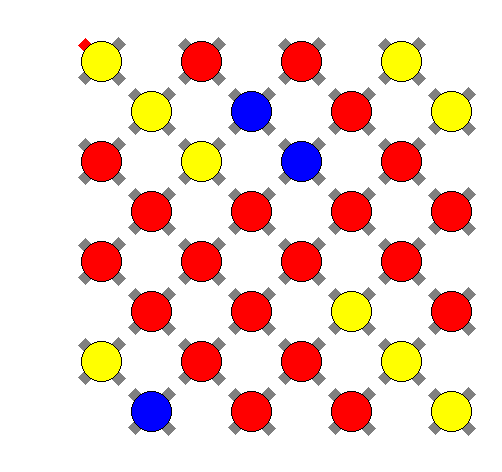

--Rule 1 passed
--Rule 2 passed
--Rule 3 passed
--Rule 4 passed
Checking column 0
Checking column 1
Checking column 2
Checking column 3
Checking column 4
Checking column 5
Checking column 6
Checking column 7
Checking column 8
--Rule 5 passed
Current possibilities: 


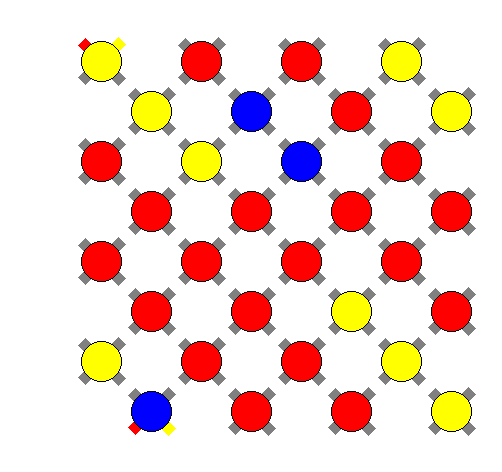

--Rule 1 passed
--Rule 2 passed
--Rule 3 passed
--Rule 4 passed
Checking column 0
Checking column 1
Checking column 2
Checking column 3
Checking column 4
Checking column 5
Checking column 6
Checking column 7
Checking column 8
--Rule 5 passed
Current possibilities: 


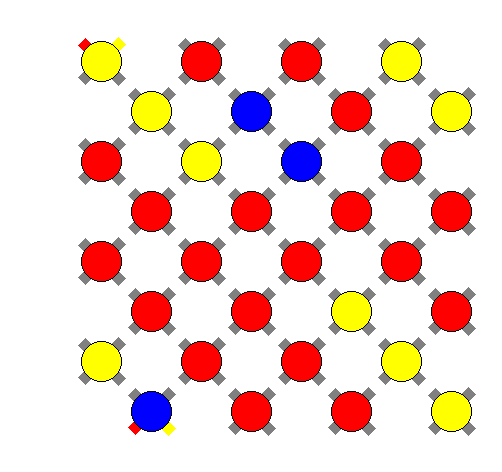

--Rule 1 passed
--Rule 2 passed
--Rule 3 passed
--Rule 4 passed
Checking column 0
Checking column 1
Checking column 2
Checking column 3
Checking column 4
Checking column 5
Checking column 6
Checking column 7
Checking column 8
--Rule 5 passed
Updated possibilities 0 times.


TypeError: '>' not supported between instances of 'list' and 'int'

In [364]:
target_design=[['#ffff00', '#ff0000', '#ff0000', '#ffff00'],
               ['#ffff00', '#0000ff', '#ff0000', '#ffff00'],
               ['#ff0000', '#ffff00', '#0000ff', '#ff0000'],
               ['#ff0000', '#ff0000', '#ff0000', '#ff0000'],
               ['#ff0000', '#ff0000', '#ff0000', '#ff0000'],
               ['#ff0000', '#ff0000', '#ffff00', '#ff0000'],
               ['#ffff00', '#ff0000', '#ff0000', '#ffff00'],
               ['#0000ff', '#ff0000', '#ff0000', '#ffff00']]

solver= Solver(target_design)
solver.solve()